# SARIMAX

## 1. Load data

In [68]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_dir = "../data/processed"

# Load BMRS data (generation, demand, prices)
df_observed = pd.read_csv(
    os.path.join(data_dir, "bmrs_data.csv"), 
    parse_dates=["SETTLEMENT_DATE"]
)

# Load NESO forecasts
df_forecasts = pd.read_csv(
    f"{data_dir}/neso_forecasts.csv", 
    parse_dates=["TARGET_DATE", "ISSUE_DATE"]
)

# Sort by date and settlement period
df_observed.sort_values(["SETTLEMENT_DATE", "SETTLEMENT_PERIOD"], inplace=True)
df_forecasts.sort_values(
    ["TARGET_DATE", "TARGET_PERIOD", "ISSUE_DATE", "ISSUE_PERIOD"], 
    inplace=True
)

# Check for NaNs
if df_observed.isna().values.any(): 
    print("Warning: BMRS dataset has NaN values.")

if df_forecasts.isna().values.any(): 
    print("Warning: NESO dataset has NaN values.")

In [73]:
df_forecasts.head()

,ISSUE_DATE,TARGET_DATE,TARGET_PERIOD,DEMAND_FORECAST,WIND_FORECAST,WIND_CAPACITY,EMBEDDED_WIND_FORECAST,EMBEDDED_SOLAR_FORECAST,ISSUE_PERIOD
0,2021-01-01,2021-01-02,1,26917.0,2383.0,15729.0,879.0,0.0,18.0
1,2021-01-01,2021-01-02,2,26917.0,2382.0,15729.0,867.0,0.0,18.0
2,2021-01-01,2021-01-02,3,26917.0,2398.0,15729.0,867.0,0.0,18.0
3,2021-01-01,2021-01-02,4,26917.0,2429.0,15729.0,863.0,0.0,18.0
4,2021-01-01,2021-01-02,5,26917.0,2474.0,15729.0,863.0,0.0,18.0


## 2. Exogenous features

In [82]:
from utilities.features import is_holiday, is_weekend

df = df_observed.merge(
    df_forecasts, 
    left_on=["SETTLEMENT_DATE", "SETTLEMENT_PERIOD"],
    right_on=["TARGET_DATE", "TARGET_PERIOD"],
    how="left"
)

df.rename(columns={"INDO": "demand_actual", "WIND": "wind_actual"}, inplace=True)
df.rename(
    columns={
        "DEMAND_FORECAST": "demand_forecast", 
        "WIND_FORECAST": "wind_forecast"
    }, 
    inplace=True
)

# Temporal features
# Daily periodicity (use 4*pi since there are two peak periods per day)
sp = df["SETTLEMENT_PERIOD"]
df["period_sin"] = np.sin(4 * np.pi * (sp - 1) / 48)
df["period_cos"] = np.cos(4 * np.pi * (sp - 1) / 48)
# Weekly periodicity
dow = df["SETTLEMENT_DATE"].dt.dayofweek  # type: ignore[attr-defined]
df["dayofweek_sin"] = np.sin(2 * np.pi * dow / 7)
df["dayofweek_cos"] = np.cos(2 * np.pi * dow / 7)
# Annual periodicity
month = df["SETTLEMENT_DATE"].dt.month  # type: ignore[attr-defined]
df["month_sin"] = np.sin(2 * np.pi * (month - 1) / 12)
df["month_cos"] = np.cos(2 * np.pi * (month - 1) / 12)
# Non-smooth periodic behaviour
df["is_holiday"] = is_holiday(df, "SETTLEMENT_DATE", country="GB")
df["is_weekend"] = is_weekend(df, "SETTLEMENT_DATE")

# Temporal features
temporal_cols = [
    "period_sin", "period_cos",
    "dayofweek_sin", "dayofweek_cos",
    "month_sin", "month_cos",
    "is_holiday", "is_weekend",
]

# Observed variables
actual_cols = ["demand_actual", "wind_actual"]

# Forecasted variables
forecast_cols = ["demand_forecast", "wind_forecast"]

# Keep only relevant columns
endog = df["ELECTRICITY_PRICE"].copy()
exog_temporal = df[temporal_cols].copy()
exog_actual = df[actual_cols].copy()
exog_forecast = df[forecast_cols].copy()

In [84]:
df[
    [
        "SETTLEMENT_DATE", "SETTLEMENT_PERIOD", 
        "TARGET_DATE", "TARGET_PERIOD",
        "ISSUE_DATE", "ISSUE_PERIOD"
    ]
]

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,TARGET_DATE,TARGET_PERIOD,ISSUE_DATE,ISSUE_PERIOD
0,2021-01-01,1,NaT,NaN,NaT,NaN
1,2021-01-01,2,NaT,NaN,NaT,NaN
2,2021-01-01,3,NaT,NaN,NaT,NaN
3,2021-01-01,4,NaT,NaN,NaT,NaN
4,2021-01-01,5,NaT,NaN,NaT,NaN
...,...,...,...,...,...,...
68203,2024-12-31,44,2024-12-31,44.0,2024-12-30,18.0
68204,2024-12-31,45,2024-12-31,45.0,2024-12-30,18.0
68205,2024-12-31,46,2024-12-31,46.0,2024-12-30,18.0
68206,2024-12-31,47,2024-12-31,47.0,2024-12-30,18.0


## 3. Train-test split

In [121]:
# Train/test split by date
n_train = 48*7*4 # 4 weeks of training data
n_test = 48  # 1 day

# Train set
endog_train = endog.iloc[-(n_train+n_test):-n_test]
exog_train = pd.concat([
    exog_temporal.iloc[-(n_train+n_test):-n_test],
    exog_actual.iloc[-(n_train+n_test):-n_test]
], axis=1)

# Test set
endog_test = endog.iloc[-n_test:]
exog_test = pd.concat([
    exog_temporal.iloc[-n_test:],
    exog_forecast.iloc[-n_test:]
], axis=1)

## 4. Model specification

In [122]:
import statsmodels.api as sm

order = (4, 1, 1)
seasonal_order = (1, 1, 0, 48)
# seasonal_order = (0, 0, 0, 0)

model = sm.tsa.SARIMAX(
    endog=endog_train,
    order=order,
    seasonal_order=seasonal_order,
    exog=exog_train
)

## 5. Fit model to observed data

In [123]:
res = model.fit()

/Users/christian/Projects/electricity_pricing/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 6. Make a forecast

In [127]:
from utilities.evaluation import rmse

fcast = res.get_forecast(steps=n_test, exog=exog_test)
fcast = fcast.summary_frame()

# Compute forecasting error
error = rmse(fcast["mean"].values, endog_test.values)
print(f"RMSE: {error:.2f} £/MWh")

RMSE: 21.91 £/MWh


## 7. Plot results

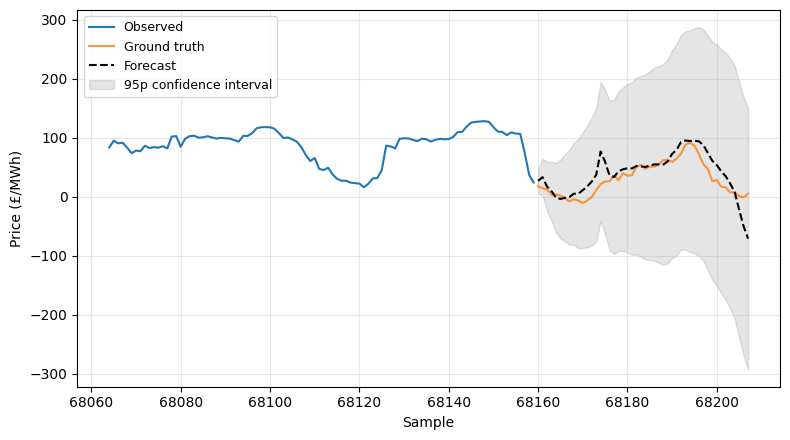

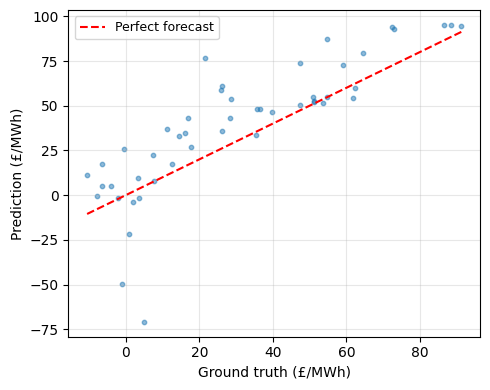

In [129]:
fig, ax = plt.subplots(figsize=(16/2, 9/2), layout="tight")
endog_train.iloc[-(2*n_test):].plot(ax=ax, label="Observed")
ax.plot(endog_test, label="Ground truth", alpha=0.8)
fcast['mean'].plot(ax=ax, style='k--', label="Forecast")
ax.fill_between(
    fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], 
    color='k', alpha=0.1, label="95p confidence interval"
)
ax.set_xlabel("Sample", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.show()

fig, ax = plt.subplots(figsize=(5, 4), layout="tight")
ax.scatter(endog_test, fcast['mean'], alpha=0.5, s=10)
ax.plot(
    [endog_test.min(), endog_test.max()],
    [endog_test.min(), endog_test.max()],
    "r--", label="Perfect forecast",
)
ax.set_xlabel("Ground truth (£/MWh)", fontsize=10)
ax.set_ylabel("Prediction (£/MWh)", fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.show()

## 8. Study residuals

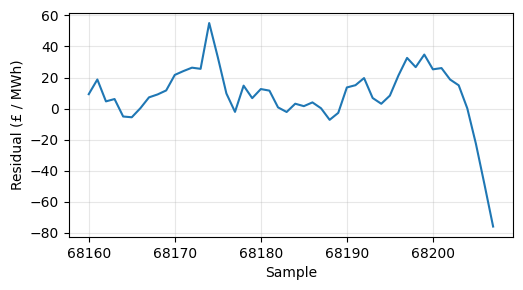

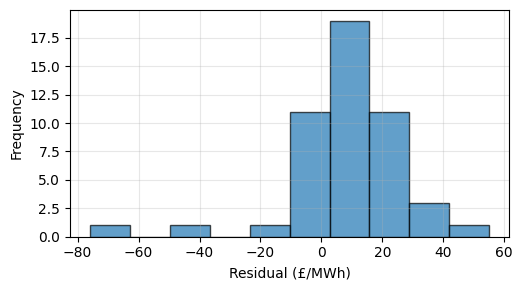

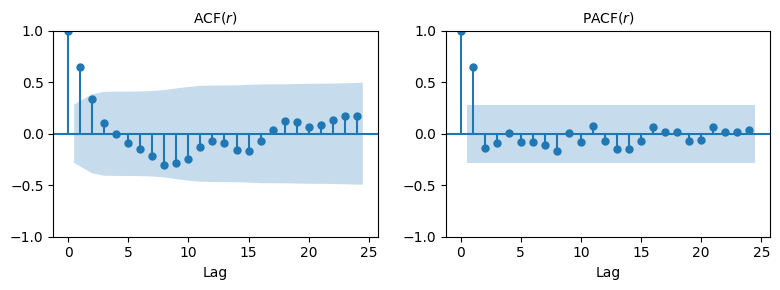

In [130]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Compute residuals
pred = fcast['mean']
actual = endog_test
resi = pred - actual
rel_resi = resi / actual

fig, ax = plt.subplots(figsize=(16/3, 9/3), layout="tight")
ax.plot(resi)
ax.set_xlabel("Sample", fontsize=10)
ax.set_ylabel("Residual (£ / MWh)", fontsize=10)
ax.grid(True, alpha=0.3)
plt.show()

# Histogram of residuals
fig, ax = plt.subplots(figsize=(16/3, 9/3), layout="tight")
ax.hist(resi, bins=10, edgecolor='black', alpha=0.7)
ax.set_xlabel("Residual (£/MWh)", fontsize=10)
ax.set_ylabel("Frequency", fontsize=10)
ax.grid(True, alpha=0.3)
plt.show()

# Plot (partial) autocorrelations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")

# ACF
plot_acf(resi, lags=24, ax=ax1)
ax1.set_title("ACF($r$)", fontsize=10)
ax1.set_xlabel("Lag", fontsize=10)

# PACF
plot_pacf(resi, lags=24, ax=ax2)
ax2.set_title("PACF($r$)", fontsize=10)
ax2.set_xlabel("Lag", fontsize=10)
plt.show()